Importing Libraries

In [34]:
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset


from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

from torch_geometric.nn import GCNConv, GATConv, SimpleConv
from torch_geometric.transforms import Constant
import pickle


device = torch.device("cuda") # Set device (use GPU if available)
filename = 'records1.dat'

In [35]:
def save_memo(memo, filename = filename):
    with open(filename, 'wb') as f:
        pickle.dump(memo, f)

def load_memo(filename = filename):
    try:
        with open(filename, 'rb') as f:
            memo = pickle.load(f)
            return memo
    except FileNotFoundError:
        print("Memo file not found. Returning an empty dictionary.")
        return {}

In [36]:
Memo = load_memo()

Memo file not found. Returning an empty dictionary.


In [37]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, split='train', transform=None):
         # Initialize the dataset with the root directory, split, and optional transform
        self.root = root
        self.split = split
        self.transform = transform
        self.graph_files = []

        classes = os.listdir(root) # Get the list of classes (subdirectories) in the root directory

        # Iterate through each class
        for class_folder in classes:
            class_path = os.path.join(root, class_folder)
            
            # Check if the class folder is a directory
            if os.path.isdir(class_path):
                # Create the path to the split folder (train, test, etc.) within the class folder
                split_folder = os.path.join(class_path, split)
                
                # Get the list of graph files (with the .gph extension) in the split folder
                graph_files = [os.path.join(split_folder, f) for f in os.listdir(split_folder) if f.endswith('.gph')]
                
                # Extend the list of graph files in the dataset with the current class's graph files
                self.graph_files.extend(graph_files)

    def __len__(self): # Return the total number of graph files in the dataset
        return len(self.graph_files)

    def __getitem__(self, idx):
        # Get the file path of the graph file at the specified index
        graph_file = self.graph_files[idx]
        
        # Load the graph data from the file using torch
        data = torch.load(graph_file)
        
        # Add ground truth label based on class (assuming class names in the file paths)
        class_label = None
        for i, class_name in enumerate(['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night', 'sofa', 'table', 'toilet']):
            if class_name in graph_file:
                class_label = i
                break

        # Check if class_label is still None, indicating an unknown class
        if class_label is None:
            raise ValueError(f"Unknown class for file: {graph_file}")

        # Set the ground truth label as a tensor in the 'y' attribute of the graph data
        data.y = torch.tensor([class_label], dtype=torch.long)

        # Apply the transform if provided
        if self.transform:
            data = self.transform(data)

        return data


# Load the graph data using the CustomGraphDataset
def load_graph_data(filepath):
    dataset = CustomGraphDataset(filepath, transform=None)
    return dataset

# Genetic Algorithm

In [38]:
population_size = 10
mutation_rate = 0.2
tournament_size = 4
num_gens = 40
root_path = '3DGraphz7'

hyperparameters = {
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "batch_size": [4, 8, 16, 32, 64, 128],
    "layer_type": [GCNConv, GATConv],  # The type of GNN layers to use
    "hidden": [0, 4, 8, 16, 32, 64, 128],  # The number of hidden units in each layer
    "weight_decay": [1e-5, 5e-4, 1e-3],  # The rate at which weights decay for regularization
    "activation": [torch.relu, torch.tanh, torch.sigmoid],  # The activation function to use in the hidden layers
    "pooling": [global_add_pool, global_mean_pool, global_max_pool],
    "epochs": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

Encoding = ["layer_type", "hidden", "hidden", "hidden", "hidden", "activation", "pooling", "learning_rate", "batch_size", "weight_decay", "epochs"]
Range_of_parameters = [len(hyperparameters[y]) for y in Encoding]

In [39]:
def generate_population(n, m):
    permutations_list = []
    while len(permutations_list) < n:
        permutation = []
        for i in range(m):
            permutation.append(random.choice(range(Range_of_parameters[i])))
        if permutation not in permutations_list:
            permutations_list.append(permutation)
    return permutations_list

def n_crossover(parent1, parent2):
    offspring1 = parent1.copy()
    offspring2 = parent2.copy()
    for i in range(len(parent1)):
        if i % 2 == 0:
            offspring1[i] = parent1[i]
            offspring2[i] = parent2[i]
        else:
            offspring1[i] = parent2[i]
            offspring2[i] = parent1[i]
    return [offspring1, offspring2]

def mutate(person, perc):
    mutated_person = person.copy()
    while random.random() < perc:
        i = random.randint(0,len(mutated_person) - 1)
        inc = random.choice([1, -1])
        mutated_person[i] = (mutated_person[i] + inc) % Range_of_parameters[i]
    return mutated_person

In [40]:
def fitness_based_selection(population,fitness_function ,crossover_function, mutation_function, mutation_rate, allow_parents = True):
    fitness_values = [fitness_function(individual) for individual in population]
    new_population = []
    
    if allow_parents == True:
        new_population = population.copy()
    
    for i in range(len(population)):
        offsprings = []
        index = 0
        print(offsprings)
        while(len(offsprings) < 2):
            parent1 = random.choices(population, weights=fitness_values)[0]
            parent2 = random.choices(population, weights=fitness_values)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population

def ranked_based_selection(population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents=True):
    sorted_population = sorted(population, key=lambda x: fitness_function(x))
    population_size = len(population)

    selection_weights = [i for i in range(1, population_size + 1)]
    
    new_population = []
    if allow_parents:
        new_population = sorted_population.copy()
    
    for i in range(len(population)):
        
        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            parent1 = random.choices(sorted_population, weights=selection_weights)[0]
            parent2 = random.choices(sorted_population, weights=selection_weights)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population

def tournament_ranked_based_selection(population,fitness_function, crossover_function, mutation_function, mutation_rate, tournament_size=2, allow_parents=True):
    new_population = []

    if allow_parents:
        new_population = population.copy()
   
    for i in range(len(population)):

        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            tournament_individuals = random.sample(population, tournament_size)
            sorted_tournament = sorted(tournament_individuals, key=lambda x: fitness_function(x))

            
            selection_weights = [i for i in range(1, tournament_size + 1)]

            parent1 = random.choices(sorted_tournament, weights=selection_weights)[0]
            parent2 = random.choices(sorted_tournament, weights=selection_weights)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    
    return new_population

def tournament_fitness_based_selection(population,fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents=True):
    new_population = []
    if allow_parents:
        new_population = population.copy()
    
    for i in range(len(population)):
        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            tournament_individuals = random.sample(population, tournament_size)
            tournament_fitness_values = [fitness_function(individual) for individual in tournament_individuals]
            
            parent1 = random.choices(tournament_individuals, weights=tournament_fitness_values)[0]
            parent2 = random.choices(tournament_individuals, weights=tournament_fitness_values)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break

        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population


In [41]:
def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)[::-1]

def truncation(population,fitness_function, npop):
    fitness_values = [fitness_function(individual) for individual in population]
    indexes = argsort(fitness_values)[:npop]
    selected_population = [population[index] for index in indexes]
    return selected_population

def binary_tournament(population,fitness_function, npop):
    retained_population = []
    while len(retained_population) < npop:
        ind1, ind2 = random.sample(population, 2)
        winner = ind1 if fitness_function(ind1) > fitness_function(ind2) else ind2
        retained_population.append(winner)
    
    return retained_population

def genetic_algorithm(population, fitness_function, parent_selection_function = fitness_based_selection, survival_function = truncation, crossover_function = n_crossover, mutation_function = mutate, mutation_rate = 0.2, allow_parents = True):
    new_population = parent_selection_function(population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents)
    return survival_function(new_population, fitness_function, len(population))

def genetic_algorithm_n_gens(population,fitness_function, parent_selection_function = fitness_based_selection, survival_function = truncation, crossover_function = n_crossover, mutation_function = mutate, mutation_rate = 0.2, allow_parents = True,n_gens = num_gens, plot = True, display_last_gen = True):
    
    n = len(population)
    
    fitness_scores = [fitness_function(individual) for individual in population]
    best_scores = [sorted(fitness_scores)[-1]]
    average_scores = [sum(fitness_scores) / len(fitness_scores)]
    
    new_population = population.copy()
    
    title = f'{parent_selection_function.__name__} + {survival_function.__name__}'
    for i in range(n_gens):
        print(f"Gen {i}: ")
        new_population = parent_selection_function(new_population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents)
        new_population = survival_function(new_population, fitness_function, n)
        fitness_scores = [fitness_function(individual) for individual in new_population]
        best_scores += [sorted(fitness_scores)[-1]]
        average_scores += [sum(fitness_scores) / len(fitness_scores) ]
    
    if plot == True:
        # Plotting the data


        plt.plot(best_scores, color='blue', label='Best Score')
        plt.plot(average_scores, color='red', label='Average Score')
        plt.xlabel('Generation')
        plt.ylabel('Score')
        plt.legend()
        plt.title(f'Optimizing {fitness_function.__name__} with {parent_selection_function.__name__} + {survival_function.__name__}')

        plt.tight_layout()
        plt.show()
        
        
    if display_last_gen == True:
        print(f'Generation: {n_gens} with {parent_selection_function.__name__} and {survival_function.__name__}')
        for i in range(population_size):
            print(f'{i+1}. Path = {new_population[i]}, Score = {fitness_function(new_population[i]):.4f}')
    save_memo(Memo, filename)
    return title, best_scores, average_scores

In [42]:
class GNNModelEA0(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA0, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

class GNNModelEA1(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA1, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = None
        self.out = layer(hidden_dim[0], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)
    
class GNNModelEA2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA2, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.out = layer(hidden_dim[1], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

class GNNModelEA3(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA3, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.hidden2 = layer(hidden_dim[1], hidden_dim[2])
        self.out = layer(hidden_dim[2], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden2(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)
    
class GNNModelEA4(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16, 16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA4, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.hidden2 = layer(hidden_dim[1], hidden_dim[2])
        self.hidden3 = layer(hidden_dim[2], hidden_dim[3])
        self.out = layer(hidden_dim[3], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden2(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden3(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

# Train the GNN model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for data in train_loader:
        data = data.to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = output.max(1)
        total_train += data.y.size(0)
        correct_train += predicted.eq(data.y).sum().item()

    accuracy_train = correct_train / total_train
    average_loss = total_loss / len(train_loader)
    return accuracy_train, average_loss

# Evaluate the GNN model
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_eval = 0
    total_eval = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device) 
            output = model(data)
            loss = criterion(output, data.y)

            total_loss += loss.item()

            _, predicted = output.max(1)
            total_eval += data.y.size(0)
            correct_eval += predicted.eq(data.y).sum().item()

    accuracy_eval = correct_eval / total_eval
    average_loss = total_loss / len(loader)
    return accuracy_eval, average_loss

# Main function to train and evaluate the GNN model
def fitness_function(person, epochs = 20):
    person = tuple(person)
    if Memo.get(person):
        return Memo[person]

    layer_type = hyperparameters[Encoding[0]][person[0]]
    hidden_dim = [hyperparameters[Encoding[1]][person[1]], hyperparameters[Encoding[2]][person[2]], hyperparameters[Encoding[3]][person[3]], hyperparameters[Encoding[4]][person[4]]]
    models = [GNNModelEA0, GNNModelEA1, GNNModelEA2, GNNModelEA3, GNNModelEA4]
    for i in range(len(hidden_dim)):
        if hidden_dim[i] == 0:
            break
    GNNmodel = models[i]
    activation_func = hyperparameters[Encoding[5]][person[5]]
    pooling = hyperparameters[Encoding[6]][person[6]]
    lr = hyperparameters[Encoding[7]][person[7]]
    batch_size = hyperparameters[Encoding[8]][person[8]]
    weight_decay = hyperparameters[Encoding[9]][person[9]]
    epochs = hyperparameters[Encoding[10]][person[10]]
    
    print("Layer Type:", layer_type.__name__)
    print("Hidden Dimensions:", hidden_dim)
    print("Activation Function:", activation_func.__name__)
    print("Pooling Function:", pooling.__name__)
    print("Learning Rate:", lr)
    print("Batch Size:", batch_size)
    print("Weight Decay:", weight_decay)
    print("Epochs:", epochs)
    
    # Define the output path for saving the trained model
    output_path = 'Saved/' + root_path + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    output_path += 'model.pt'


    # Create training and testing datasets
    train_dataset = CustomGraphDataset(root_path, split='train')
    test_dataset = CustomGraphDataset(root_path, split='test')
    # Define GNN model
    input_dim = 7
    output_dim = 10
    model = GNNmodel(input_dim, output_dim, hidden_dim=hidden_dim, activation_func=activation_func, layer=layer_type, pooling=pooling).to(device)
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.NLLLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate the model before training and print initial results
    test_acc, test_loss = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {0}/{epochs} => 'f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Lists to store results for plotting
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Train the model and capture results
    for epoch in range(1, epochs + 1):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion, device)
        test_acc, test_loss = evaluate(model, test_loader, criterion, device)

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | '
                  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    Memo[person] = test_accuracies[-1]
    # Save the trained model
    #model.save_model(output_path)
    return test_accuracies[-1]


In [43]:
def print_gene_details(index, person):

    layer_type = hyperparameters[Encoding[0]][person[0]]
    hidden_dims = [hyperparameters[Encoding[1]][person[1]], hyperparameters[Encoding[2]][person[2]], hyperparameters[Encoding[3]][person[3]], hyperparameters[Encoding[4]][person[4]]]
    activation_func = hyperparameters[Encoding[5]][person[5]]
    pooling = hyperparameters[Encoding[6]][person[6]]
    lr = hyperparameters[Encoding[7]][person[7]]
    batch_size = hyperparameters[Encoding[8]][person[8]]
    weight_decay = hyperparameters[Encoding[9]][person[9]]

    print(f"Gene {index} Details:")
    print("Layer Type:", layer_type.__name__)
    print("Hidden Dimensions:", hidden_dims)
    print("Activation Function:", activation_func.__name__)
    print("Pooling Function:", pooling.__name__)
    print("Learning Rate:", lr)
    print("Batch Size:", batch_size)
    print("Weight Decay:", weight_decay)

In [32]:
persons = generate_population(10, 11)

In [44]:
index = 0
for person in persons:
    print(f'Gene {index + 1}: ')
    fitness_function(person)
    index += 1

Gene 1: 
Layer Type: GATConv
Hidden Dimensions: [128, 32, 128, 16]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.05
Batch Size: 32
Weight Decay: 0.001
Epochs: 100


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/100 => Test Loss: 119.9474, Test Accuracy: 0.0810
Epoch 10/100 => Train Loss: 9.9158, Train Accuracy: 0.1275 | Test Loss: 9.8431, Test Accuracy: 0.1242
Epoch 20/100 => Train Loss: 10.7206, Train Accuracy: 0.1366 | Test Loss: 13.3629, Test Accuracy: 0.1242
Epoch 30/100 => Train Loss: 46.1628, Train Accuracy: 0.1300 | Test Loss: 21.1157, Test Accuracy: 0.1020
Epoch 40/100 => Train Loss: 9.8350, Train Accuracy: 0.1429 | Test Loss: 8.6597, Test Accuracy: 0.1111
Epoch 50/100 => Train Loss: 8.7292, Train Accuracy: 0.1243 | Test Loss: 11.9591, Test Accuracy: 0.1111
Epoch 60/100 => Train Loss: 7.3452, Train Accuracy: 0.1332 | Test Loss: 10.9494, Test Accuracy: 0.1203
Epoch 70/100 => Train Loss: 10.9267, Train Accuracy: 0.1310 | Test Loss: 21.6932, Test Accuracy: 0.1242
Epoch 80/100 => Train Loss: 12.0339, Train Accuracy: 0.1265 | Test Loss: 29.5387, Test Accuracy: 0.1111
Epoch 90/100 => Train Loss: 8.8700, Train Accuracy: 0.1234 | Test Loss: 13.8224, Test Accuracy: 0.1007
Epoch 100/100

In [46]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20)

Gen 0: 
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Layer Type: GATConv
Hidden Dimensions: [128, 16, 4, 16]
Activation Function: sigmoid
Pooling Function: global_max_pool
Learning Rate: 0.01
Batch Size: 128
Weight Decay: 0.001
Epochs: 80
Epoch 0/80 => Test Loss: 2.3627, Test Accuracy: 0.1085
Epoch 10/80 => Train Loss: 1.2875, Train Accuracy: 0.5989 | Test Loss: 1.5434, Test Accuracy: 0.4379
Epoch 20/80 => Train Loss: 1.0093, Train Accuracy: 0.6450 | Test Loss: 1.2995, Test Accuracy: 0.4719
Epoch 30/80 => Train Loss: 0.8703, Train Accuracy: 0.6863 | Test Loss: 1.1960, Test Accuracy: 0.5255
Epoch 40/80 => Train Loss: 0.7949, Train Accuracy: 0.7299 | Test Loss: 1.0859, Test Accuracy: 0.5791
Epoch 50/80 => Train Loss: 0.7414, Train Accuracy: 0.7520 | Test Loss: 1.0316, Test Accuracy: 0.6301
Epoch 60/80 => Train Loss: 0.6424, Train Accuracy: 0.7886 | Test Loss: 0.9523, Test Accuracy: 0.6745
Epoch 70/80 => Train Loss: 0.5782, Train Accuracy: 0.8135 | Test Loss: 0.9057, Test Accuracy: 0.6993
Epoch 80/80 =>

KeyboardInterrupt: 

In [47]:
save_memo(Memo)

Gen 0: 
Layer Type: GATConv
Hidden Dimensions: [8, 8, 0, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.005
Batch Size: 128
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 108.9927, Test Accuracy: 0.1085
Epoch 10/20 => Train Loss: 4.0764, Train Accuracy: 0.2831 | Test Loss: 4.8315, Test Accuracy: 0.2536
Epoch 20/20 => Train Loss: 2.6375, Train Accuracy: 0.4339 | Test Loss: 3.4582, Test Accuracy: 0.2771
Layer Type: GCNConv
Hidden Dimensions: [4, 4, 4, 32]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.01
Batch Size: 16
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 85.4041, Test Accuracy: 0.1020
Epoch 10/20 => Train Loss: 6.1450, Train Accuracy: 0.2073 | Test Loss: 5.8854, Test Accuracy: 0.1935
Epoch 20/20 => Train Loss: 3.7793, Train Accuracy: 0.2837 | Test Loss: 5.4817, Test Accuracy: 0.2484
Layer Type: GCNConv
Hidden Dimensions: [8, 8, 4, 0]
Activation Function: relu
Pooling Function: global_max_pool
Learning Rate: 0.01


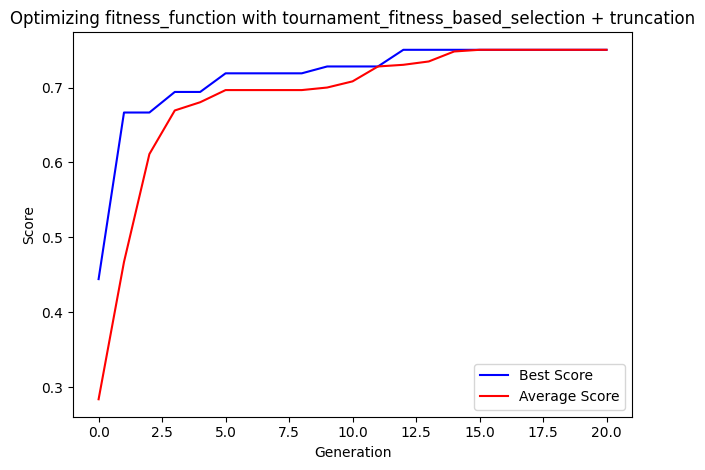

Generation: 20 with tournament_fitness_based_selection and truncation
1. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
2. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
3. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
4. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
5. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
6. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
7. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
8. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
9. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
10. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503


('tournament_fitness_based_selection + truncation',
 [0.4444444444444444,
  0.6666666666666666,
  0.6666666666666666,
  0.6941176470588235,
  0.6941176470588235,
  0.7189542483660131,
  0.7189542483660131,
  0.7189542483660131,
  0.7189542483660131,
  0.7281045751633987,
  0.7281045751633987,
  0.7281045751633987,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209],
 [0.28418300653594775,
  0.4673202614379085,
  0.6112418300653595,
  0.6694117647058823,
  0.6803921568627451,
  0.6966013071895425,
  0.6966013071895425,
  0.6966013071895425,
  0.6966013071895425,
  0.7,
  0.7082352941176471,
  0.7281045751633987,
  0.7303267973856209,
  0.7347712418300654,
  0.7481045751633987,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209])

In [ ]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_fitness_based_selection)

Layer Type: GATConv
Hidden Dimensions: [8, 16, 128, 32]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.05
Batch Size: 64
Weight Decay: 1e-05


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/20 => Test Loss: 3.5890, Test Accuracy: 0.0863
Epoch 10/20 => Train Loss: 1.6278, Train Accuracy: 0.4017 | Test Loss: 1.7600, Test Accuracy: 0.3529
Epoch 20/20 => Train Loss: 1.5897, Train Accuracy: 0.4222 | Test Loss: 1.7588, Test Accuracy: 0.3438
Layer Type: GATConv
Hidden Dimensions: [32, 32, 4, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.1
Batch Size: 16
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 100.2208, Test Accuracy: 0.0549
Epoch 10/20 => Train Loss: 27.4891, Train Accuracy: 0.1319 | Test Loss: 44.4711, Test Accuracy: 0.0941
Epoch 20/20 => Train Loss: 24.4951, Train Accuracy: 0.1303 | Test Loss: 51.1555, Test Accuracy: 0.1020
Layer Type: GCNConv
Hidden Dimensions: [0, 8, 64, 128]
Activation Function: tanh
Pooling Function: global_add_pool
Learning Rate: 0.001
Batch Size: 32
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 91.5610, Test Accuracy: 0.0706
Epoch 10/20 => Train Loss: 46.6178, Train Accuracy: 0.2679 | Test Loss: 54.5953, T

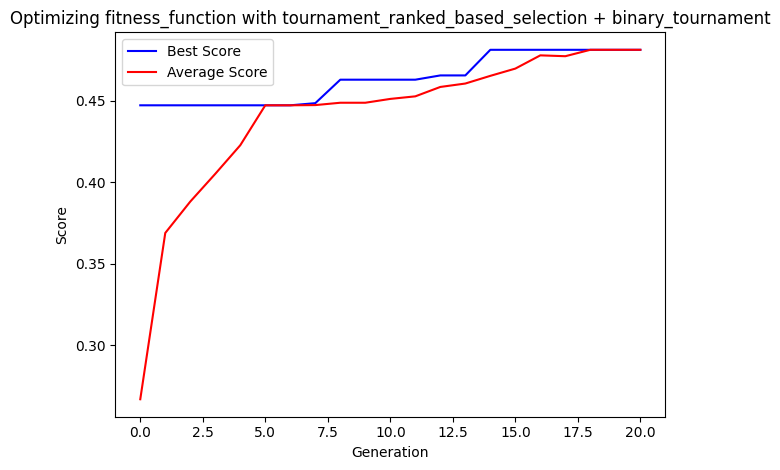

Generation: 20 with tournament_ranked_based_selection and binary_tournament
1. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
2. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
3. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
4. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
5. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
6. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
7. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
8. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
9. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
10. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810


('tournament_ranked_based_selection + binary_tournament',
 [0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.44836601307189544,
  0.4627450980392157,
  0.4627450980392157,
  0.4627450980392157,
  0.4627450980392157,
  0.465359477124183,
  0.465359477124183,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694],
 [0.26705882352941174,
  0.36888888888888893,
  0.3881045751633987,
  0.40509803921568627,
  0.42261437908496735,
  0.4470588235294118,
  0.4470588235294118,
  0.44718954248366016,
  0.44862745098039214,
  0.44862745098039214,
  0.45098039215686275,
  0.4525490196078431,
  0.4583006535947713,
  0.46039215686274515,
  0.4650980392156863,
  0.46954248366013074,
  0.4776470588235294,
  0.4771241830065359,
  0.4810457516339869,
  0.4810457516339869,
  0.4810457516339869])

In [ ]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_ranked_based_selection, survival_function=binary_tournament)